In [1]:
import os
os.chdir(os.path.expanduser('~/My Drive/dirclip-private/core'))

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
from jax import vmap
from jax.tree_util import tree_map, tree_leaves
from glob import glob
from functools import partial
from tqdm.auto import tqdm
import itertools
import models, datasets, distributions, utils

In [4]:
# load dataset
ds_name = 'cifar10'
x_train, y_train, n_classes = datasets.load(ds_name, 'train')
x_test,  y_test,  n_classes = datasets.load(ds_name, 'test')

In [5]:
%%time
def get_metrics(logits, y):
    logprobs = utils.average_predictions(logits)
    ds_size, n_class = logprobs.shape
    y_one_hot = jax.nn.one_hot(y, n_class)
    acc = float((logprobs.argmax(1) == y).mean())
    like = (logprobs * y_one_hot).sum()
    avg_conf = float((jax.nn.softmax(logits).max(-1)).mean())
    return acc, like, avg_conf

# load all models into pandas dataframe
models_list = []
weights_dir = os.path.expanduser('~/Downloads/weights/weights_cold')
for model_dir in tqdm(glob(f'{weights_dir}/*seed=0')):
    
    # get model config
    model_name = model_dir.rsplit('/', 1)[1]
    config = eval(f'dict({model_name})')

    # load data for all seeds
    chain = []
    logits_train = []
    logits_test = []
    for i in itertools.count():
        seed_dir = f'{model_dir[:-1]}{i}'
        if not os.path.isdir(seed_dir): break
        chain += [jnp.load(f'{seed_dir}/chain.npy', allow_pickle=True).item()]
        logits_train += [jnp.load(f'{seed_dir}/logits_train.npy')]
        logits_test += [jnp.load(f'{seed_dir}/logits_valid.npy')]
    chain = tree_map(lambda *trees: jnp.concatenate(trees), *chain)
    logits_train = jnp.concatenate(logits_train)
    logits_test = jnp.concatenate(logits_test)
    ens_size = len(logits_train)

    # compute metrics
    # when computing std and L1 norm of weights, assuming zero mean
    n_param = sum(tree_map(jnp.size, tree_leaves(chain))) / ens_size
    acc_train, like_train, conf_train = get_metrics(logits_train, y_train)
    acc_test, like_test, conf_test = get_metrics(logits_test, y_test)
    weights_l1_norm = vmap(lambda params: sum(tree_map(lambda x: jnp.abs(x).sum(), tree_leaves(params)))/n_param)(chain).mean()
    weights_std = vmap(lambda params: jnp.sqrt(sum(tree_map(lambda x: (x**2).sum(), tree_leaves(params)))/n_param))(chain).mean()

    # save model to dataframe
    models_list += [{**config, **dict(acc_train=acc_train, acc_test=acc_test, like_train=like_train, like_test=like_test,
                                      conf_train=conf_train, weights_std=weights_std, weights_l1_norm=weights_l1_norm, ens_size=ens_size)}]

  0%|          | 0/480 [00:00<?, ?it/s]

CPU times: user 4min 29s, sys: 21.3 s, total: 4min 50s
Wall time: 3min 53s


In [6]:
df = pd.DataFrame.from_dict(models_list)
df.head()

,model,ds,dist,dist_param,std,temp,augment,finetuned,lr,seed,acc_train,acc_test,like_train,like_test,conf_train,weights_std,weights_l1_norm,ens_size
0,resnet20,cifar10,categorical,0,2.24,0.2683,False,False,0.0104,0,1.00000,0.8677,-513.6027,-4510.295,0.990109,0.7972282,0.6265756,16
1,resnet20,cifar10,categorical,0,0.22,0.1389,True,False,0.0007,0,0.99776,0.9359,-2884.9712,-2076.8247,0.961875,0.09086193,0.06979372,16
2,resnet20,cifar10,categorical,0,0.05,0.1389,True,False,0.0002,0,0.98192,0.9299,-6667.1562,-2441.4624,0.919059,0.024492435,0.016919293,16
3,resnet20,cifar10,categorical,0,1.25,0.0001,False,False,0.0104,0,1.00000,0.8505,-25.06032,-4858.221,0.999499,0.1679171,0.07228548,16
4,resnet20,cifar10,categorical,0,0.07,0.2683,True,False,0.0002,0,0.97410,0.9258,-7586.029,-2531.658,0.916609,0.040877618,0.030809475,16


In [7]:
# print best model
i = df.acc_test.to_numpy().argmax()
df.iloc[i:i+1]

,model,ds,dist,dist_param,std,temp,augment,finetuned,lr,seed,acc_train,acc_test,like_train,like_test,conf_train,weights_std,weights_l1_norm,ens_size
319,resnet20,cifar10,categorical,0,0.52,0.0001,True,False,0.0104,0,1.0,0.9486,-141.15504,-1672.9777,0.997339,0.09769385,0.059378706,16


# Experiments: Normal prior

In [8]:
df_subset = df[(df.model=='resnet20') & (df.ds=='cifar10') & (df.dist=='categorical')]
scales = jnp.unique(df_subset['std'].to_numpy()) # [0.05, 0.07, 0.09, 0.12, 0.16, 0.22, 0.29, 0.39, 0.52, 0.70, 0.93, 1.25, 1.67, 2.24, 3.00]
temps = jnp.unique(df_subset.temp.to_numpy()) # [0, 0.0001, 0.0002, 0.0004, 0.0007, 0.0014, 0.0027, 0.0052, 0.0100, 0.0193, 0.0373, 0.0720, 0.1389, 0.2683, 0.5179, 1.0000]
df_aug = df_subset[df_subset.augment==True]
df_noaug = df_subset[df_subset.augment==False]

## image plots

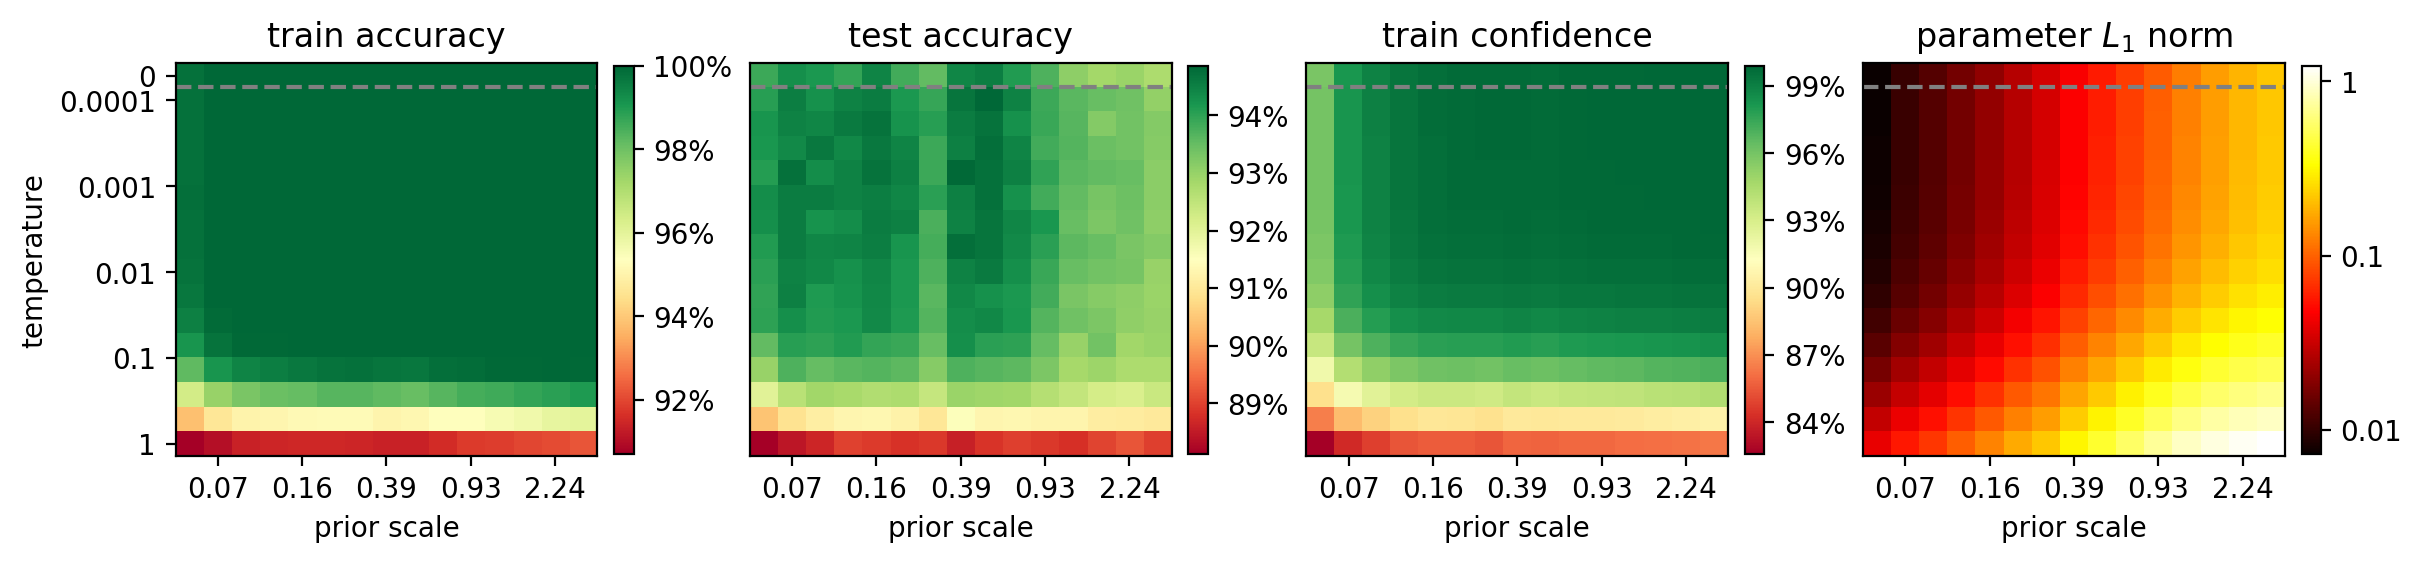

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(12, 2.7), layout='constrained')
im_kwargs = dict(aspect='auto')
colorbar_kwargs = dict(fraction=0.046, pad=0.04)
df_subset = df_aug
    
# load data
conf_train = np.zeros([len(scales), len(temps)])
acc_train = np.zeros([len(scales), len(temps)])
acc_test = np.zeros([len(scales), len(temps)])
like_test = np.zeros([len(scales), len(temps)])
weight_norm = np.zeros([len(scales), len(temps)])
for row in df_subset.itertuples():
    i1 = jnp.searchsorted(scales, row.std)
    i2 = jnp.searchsorted(temps, row.temp)
    conf_train[i1, i2] = row.conf_train
    acc_train[i1, i2] = row.acc_train
    acc_test[i1, i2] = row.acc_test
    like_test[i1, i2] = row.like_test
    weight_norm[i1, i2] = row.weights_l1_norm
    
# train accuracy
ax = axs[0]
im = ax.imshow(acc_train.T, cmap='RdYlGn', **im_kwargs)
fig.colorbar(im, ax=ax, **colorbar_kwargs, format=lambda x, _: f'{x:.0%}')
ax.set_title('train accuracy')

# test accuracy
ax = axs[1]
im = ax.imshow(acc_test.T, cmap='RdYlGn', **im_kwargs)
cbar = fig.colorbar(im, ax=ax, **colorbar_kwargs, format=lambda x, _: f'{x:.0%}')
cbar.set_ticks(ticks=np.arange(0.89, 0.95, step=0.01))
ax.set_title('test accuracy')

# train confidence
ax = axs[2]
im = ax.imshow(conf_train.T, cmap='RdYlGn', **im_kwargs)
cbar = fig.colorbar(im, ax=ax, **colorbar_kwargs, format=lambda x, _: f'{x:.0%}')
cbar.set_ticks(ticks=np.arange(0.84, 0.99, step=0.03))
ax.set_title('train confidence')

# test likelihood
# ax = axs[2]
# im = ax.imshow(like_test.T, cmap='magma', **im_kwargs)
# cbar = fig.colorbar(im, ax=ax, **colorbar_kwargs)
# ax.set_title('test likelihood')

# weights norm
ax = axs[3]
im = ax.imshow(jnp.log(weight_norm.T), cmap='hot', **im_kwargs)
cbar = fig.colorbar(im, ax=ax, **colorbar_kwargs, format=lambda x, _: f'{np.round(np.exp(x), decimals=5):g}')
cbar.set_ticks(jnp.log(jnp.array([1, 0.1, 0.01])))
ax.set_title(r'parameter $L_1$ norm')

# manually add logarithmic tick values
for ax in axs.flatten():
    ax.set_xticks(np.arange(len(scales))[1::3])
    ax.set_xticklabels(scales[1::3])
    ax.set_yticks((0, *np.linspace(1, len(temps)-1, 5)), ('0', '0.0001', '0.001', '0.01', '0.1', '1'), rotation=0)
    ax.axhline(y=0.45, c='gray', ls='--')

# label axes
axs[0].set_ylabel('temperature')
for ax in axs: ax.set_xlabel('prior scale')

# hide y axes inside figure
for ax in axs[1:]:
    ax.set(yticklabels=[])
    ax.tick_params(left=False)

# plt.savefig('../plots/temp_scale_grid.pdf')
plt.show()

# prior vs. posterior
compare confidence of prior *samples* to posterior *samples*

In [10]:
df_subset = df_aug
temp = df_subset.temp.to_numpy()
prior_scale = df_subset['std'].to_numpy()
adjusted_prior_scale = prior_scale * jnp.sqrt(temp)
post_std = df_subset.weights_std.to_numpy()
post_conf = df_subset.conf_train.to_numpy()

In [11]:
prior_scale_geomspace = jnp.geomspace(0.02, 10, 50)
prior_conf = jnp.load('../data/prior_conf.npy')
prior_conf.shape

(1600, 50)

In [12]:
def bootstrap_mean(key, data, n_samples=100):
    # generate data batches with replacement
    bootstrap_samples = jax.random.choice(key, data, (n_samples, len(data)), replace=True)
    
    # evaluate mean for each batch
    vals = vmap(jnp.mean)(bootstrap_samples)
    
    median = jnp.median(vals)
    lower = jnp.percentile(vals, 10)
    upper = jnp.percentile(vals, 90)
    return jnp.array([median, lower, upper])

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, prior_conf.shape[1])
prior_conf_interval = vmap(bootstrap_mean)(keys, prior_conf.T)
prior_conf_interval.shape

(50, 3)

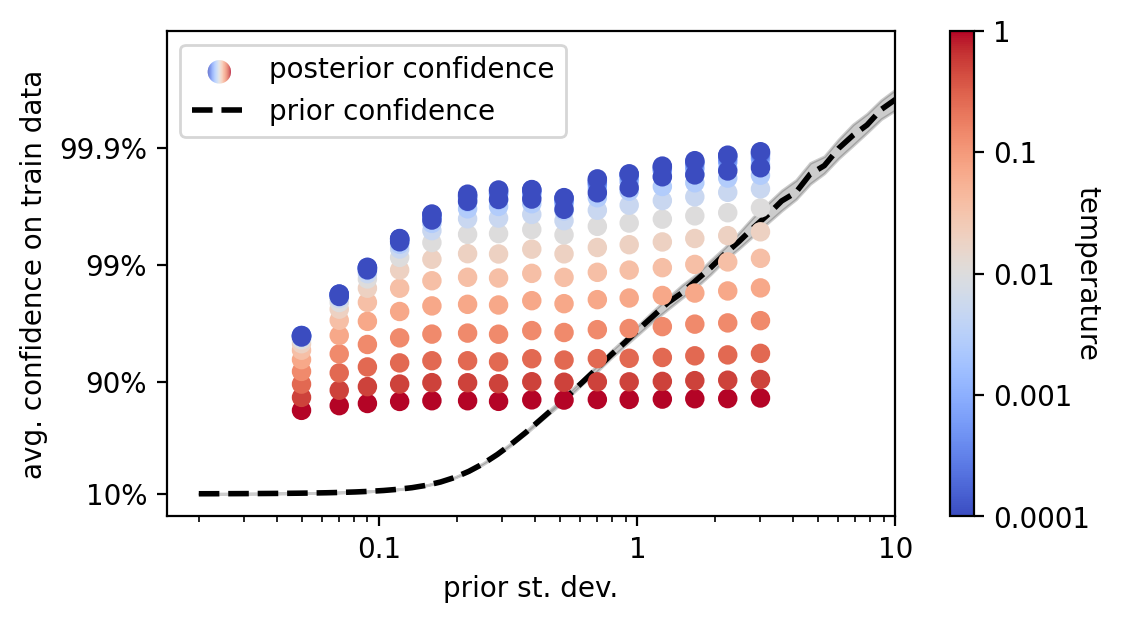

In [13]:
fig, ax = plt.subplots(figsize=(5.5, 3), layout='constrained')

# prior confidence
ax.plot(prior_scale_geomspace, prior_conf_interval[:, 0], color='black', ls='--', lw=2, label='prior confidence')
ax.fill_between(prior_scale_geomspace, prior_conf_interval[:, 1], prior_conf_interval[:, 2], alpha=0.2, color='black')

# posterior confidence
cmap = 'coolwarm'
color_norm = mpl.colors.Normalize(vmin=jnp.log(temp[temp>0]).min(), vmax=jnp.log(temp).max(), clip=True)
color_mapper = mpl.cm.ScalarMappable(norm=color_norm, cmap=cmap)
c = color_mapper.to_rgba(jnp.log(temp))
o = np.argsort(temp)[::-1] # sort points by temp. to draw coldest points on top
ax.scatter(prior_scale[o], post_conf[o], c=c[o], zorder=20)
cbar = fig.colorbar(color_mapper, ax=ax, format=lambda x, _: f'{np.round(np.exp(x), decimals=5):g}')
cbar.set_ticks(jnp.log(jnp.array([1, 0.1, 0.01, 0.001, 0.0001])))
cbar.ax.set_ylabel('temperature', rotation=-90)

# log y scale
f = lambda x: -jnp.log(1-x)
f_inv = lambda y: 1 - jnp.exp(-y)
ax.set_yscale(mpl.scale.FuncScale(ax, (f, f_inv)))
ax.set_yticks([0.1, 0.9, 0.99, 0.999])

# legend
def make_gradient_point(x=0, y=0, r=1.2, n_rectangles=50):
    w = 2.1*r / n_rectangles
    dxs = np.linspace(-r+w/10, r-w-w/10, n_rectangles)
    colors = mpl.cm.coolwarm(np.linspace(0, 1, n_rectangles))
    polys = []
    for dx in dxs:
        dx0 = dx
        dx1 = dx + w
        h0 = np.sqrt(r**2 - dx0**2)
        h1 = np.sqrt(r**2 - dx1**2)
        polys += [((x+dx0, y-h0), (x+dx0, y+h0), (x+dx1, y+h1), (x+dx1, y-h1))]
    poly_collection = mpl.collections.PolyCollection(polys, facecolors=colors, edgecolor=None)
    return poly_collection
class GradientLegendHandler:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        w, h = handlebox.width, handlebox.height
        poly_collection = make_gradient_point(x0+0.5*w, y0+0.3*h, 0.6*h)
        handlebox.add_artist(poly_collection)
        return poly_collection
handles, labels = ax.get_legend_handles_labels()
handles = (mpl.lines.Line2D([0], [0], label='posterior confidence'), *handles)
ax.legend(loc='upper left', handles=handles, handler_map={handles[0]: GradientLegendHandler()})

ax.set_ylim((-0.4, 0.9999))
ax.set_xlim((0.015, 10))
ax.set_xscale('log')
ax.xaxis.set_major_formatter(lambda x, _: f'{x:g}')
ax.yaxis.set_major_formatter(lambda x, _: f'{x:.1%}'.replace('.0', ''))
ax.set_xlabel('prior st. dev.')
ax.set_ylabel('avg. confidence on train data')
# plt.savefig('../plots/prior_vs_posterior_conf.pdf')
plt.show()